In [1]:
from operator import mod
from tomo2mesh.misc.voxel_processing import TimerGPU, edge_map, modified_autocontrast, get_values_cyl_mask, cylindrical_mask
from tomo2mesh.projects.eaton.recon import recon_binned, recon_all
from tomo2mesh.projects.eaton.params import pixel_size_1X as pixel_size
from tomo2mesh.projects.eaton.rw_utils_ae import read_raw_data_1X, save_path
from tomo2mesh.unet3d.surface_segmenter import SurfaceSegmenter
from tomo2mesh.structures.grid import Grid
from tomo2mesh.structures.patches import Patches

import cupy as cp
import numpy as np
from tomo2mesh.structures.voids import Voids
from skimage.filters import threshold_otsu
from skimage.filters import threshold_local
from cupyx.scipy import ndimage
from scipy import ndimage as ndimage_cpu
from scipy import ndimage as ndimage_cpu
import matplotlib.pyplot as plt


In [2]:
b = 1
projs, theta, center, dark, flat = read_raw_data_1X("1", "125")
# projs, theta, center, dark, flat = read_raw_data_1X("2", "2")
# projs, theta, center, dark, flat = read_raw_data_1X("3", "2")
# projs, theta, center, dark, flat = read_raw_data_1X("45", "3")
# projs, theta, center, dark, flat = read_raw_data_1X("45", "8")
# projs, theta, center, dark, flat = read_raw_data_1X("89", "3")
# projs, theta, center, dark, flat = read_raw_data_1X("89", "7")
# projs, theta, center, dark, flat = read_raw_data_1X("1011", "3")
# projs, theta, center, dark, flat = read_raw_data_1X("1011", "8")
# projs, theta, center, dark, flat = read_raw_data_1X("12", "2")

t_gpu = TimerGPU("secs")
memory_pool = cp.cuda.MemoryPool()
cp.cuda.set_allocator(memory_pool.malloc)

ntheta, nz, n = projs.shape
projs = np.mean(projs.reshape(ntheta,nz//b,b,n//b,b), axis = (2,4))
projs = np.array(projs, dtype = np.float32)
dark = np.mean(dark.reshape(nz//b, b, n//b, b), axis = (1,3))
flat = np.mean(flat.reshape(nz//b, b, n//b, b), axis = (1,3))
dark = np.array(dark.astype(np.float32), dtype = np.float32)
flat = np.array(flat.astype(np.float32), dtype = np.float32)
theta = np.array(theta, dtype = np.float32)
center = np.float32(center/float(b))

# fbp
t_gpu.tic()
V = recon_all(projs, theta, center, 32, dark, flat, pixel_size) 
V_rec = V #[:(nz//28)*28,:(n//28)*28,:(n//28)*28] 


100%|███████████████████████████████████████████| 48/48 [02:12<00:00,  2.76s/it]


In [3]:
from tomo2mesh import DataFile

# when writing
dfile = DataFile('/data01/tmpfile', tiff = True, d_shape = V.shape, d_type = V.dtype)
dfile.create_new(overwrite=True)
dfile.write_full(V)

# when reading
# dfile = DataFile('/data01/tmpfile', tiff = True)
# V = dfile.read_full(V)


Removed old contents in tiff folder tmpfile


In [4]:
# p = Patches(V_rec.shape, initialize_by = "grid", patch_size = (56,56,56))
# x = np.ones((len(p), 56,56,56))
# V_test = np.zeros((1152,2448,2448))
# p.fill_patches_in_volume(x, V_test)

# print(np.sum(V_test == 0))

# fig, ax = plt.subplots(1,1, figsize = (8,8))
# ax.imshow(V_test[100], cmap = 'gray')
# plt.show()


In [5]:
# seg_vols = []
# p_size = [144]
# for j in range(len(p_size)):
#     patches = Patches(V_rec.shape, initialize_by = "regular-grid", patch_size = (p_size[j],p_size[j],p_size[j]))
#     x_vols = patches.extract(V_rec, (p_size[j],p_size[j],p_size[j]))

#     thresh_list = []
#     for i in range(len(x_vols)):
#         thresh_list.append((x_vols[i]<threshold_otsu(x_vols[i])).astype(np.uint8))

#     V_empty = np.empty(V_rec.shape, dtype = np.uint8)
#     patches.fill_patches_in_volume(thresh_list, V_empty)
#     seg_vols.append(V_empty)
    
    
# V_seg = np.median(seg_vols, axis = 0)
# cylindrical_mask(V_seg, 1, mask_val = 1)

p_size = 144
patches = Patches(V_rec.shape, initialize_by = "bestfit_grid", patch_size = (p_size,p_size,p_size))
x_vols = patches.extract(V_rec, (p_size,p_size,p_size))

thresh_list = []
import tqdm
for i in tqdm.trange(len(x_vols)):
    thresh_list.append((x_vols[i]<threshold_otsu(x_vols[i][::3,::3,::3])).astype(np.uint8))

V_seg = np.empty(V_rec.shape, dtype = np.uint8)
patches.fill_patches_in_volume(thresh_list, V_seg)
cylindrical_mask(V_seg, 1, mask_val = 1)

100%|██████████████████████████████████████| 3179/3179 [00:10<00:00, 300.11it/s]


In [6]:
V_seg[100][0][0]

1

In [7]:
n

2448

In [8]:
print("Porosity:",(np.sum(V_seg)-(n**2)*(1-np.pi/4)*nz)/(n*n*nz*np.pi/4))

Porosity: 1.1786694921870393e-01


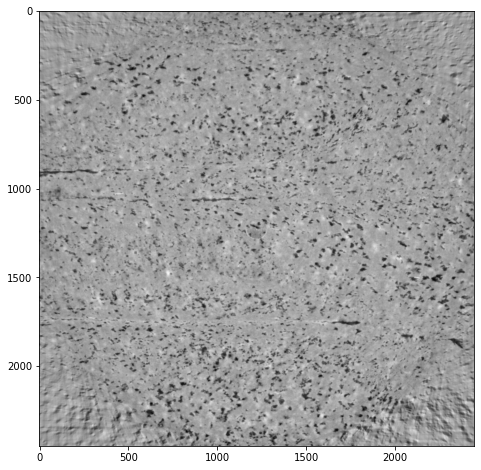

In [9]:
#Plot reconstructed slice
fig, ax = plt.subplots(1,1, figsize = (8,8))
ax.imshow(V_rec[100], cmap = 'gray')
plt.show()


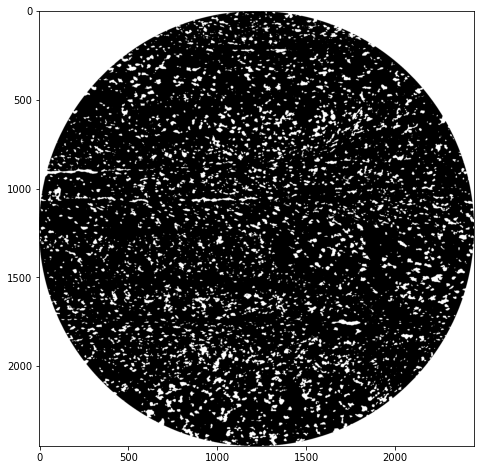

In [10]:
#Plot segmented slice
fig, ax = plt.subplots(1,1, figsize = (8,8))
ax.imshow(V_seg[100], cmap = 'gray')
plt.show()


<AxesSubplot:>

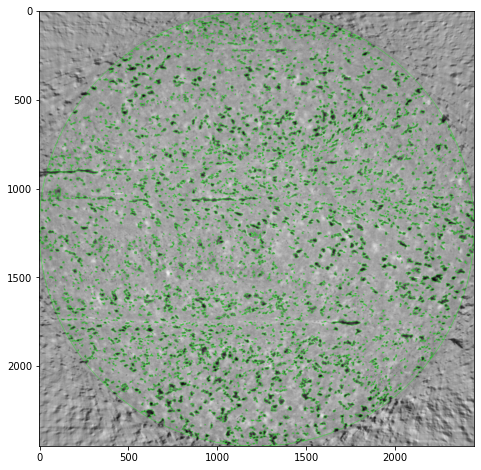

In [11]:
#Overlay plot
from tomo2mesh.misc import viewer
fig, ax = plt.subplots(1,1, figsize = (8,8))
viewer.edge_plot(V_rec[100],V_seg[100], ax)


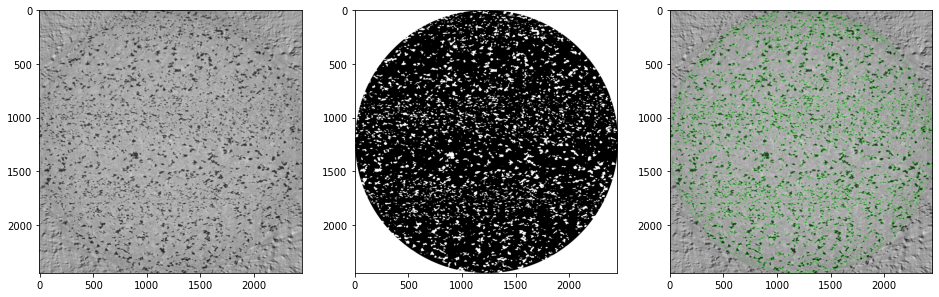

20


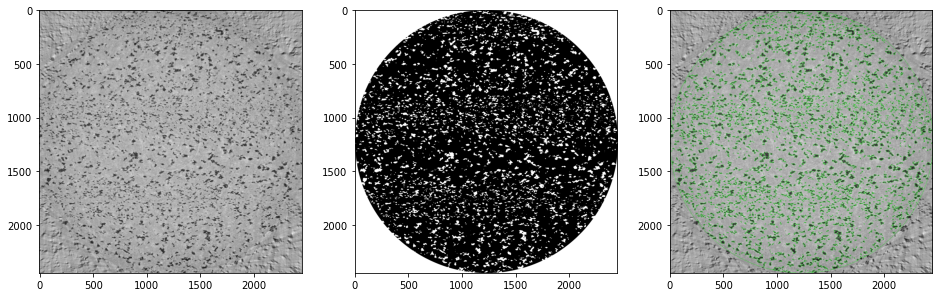

21


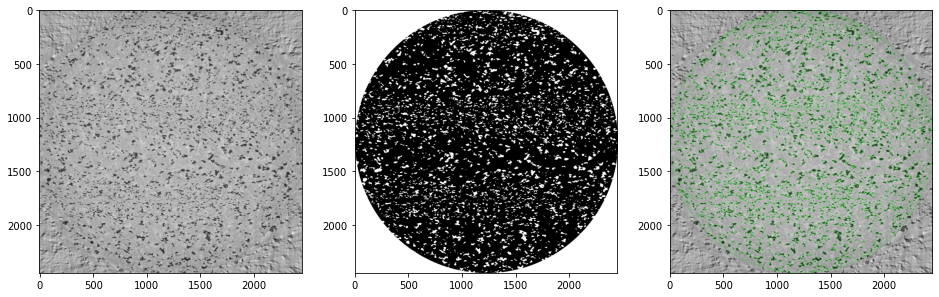

22


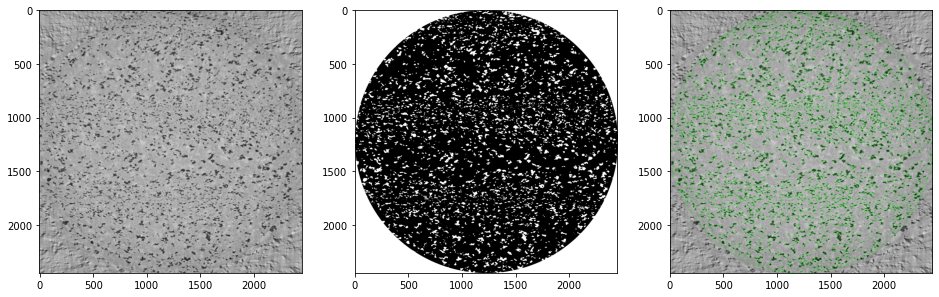

23


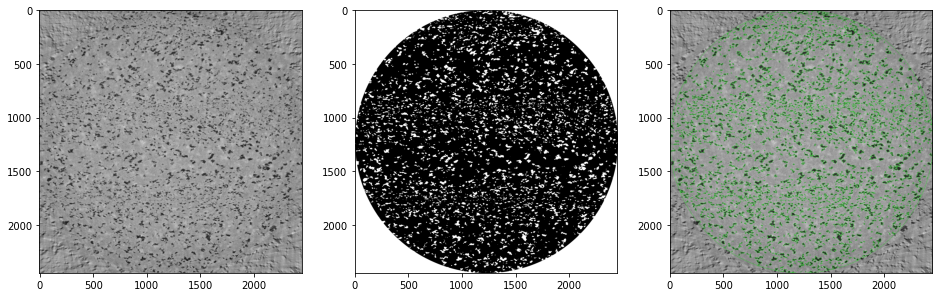

24


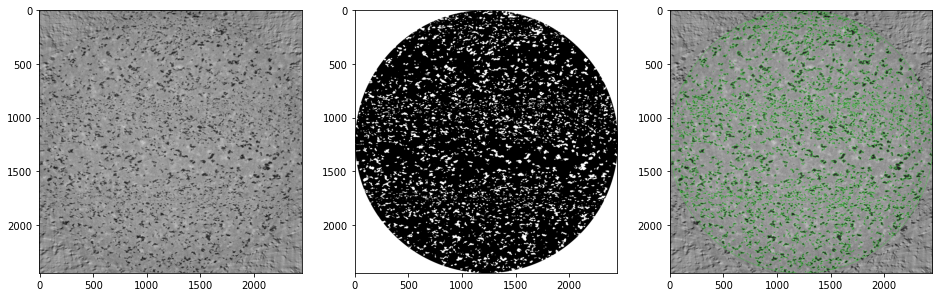

25


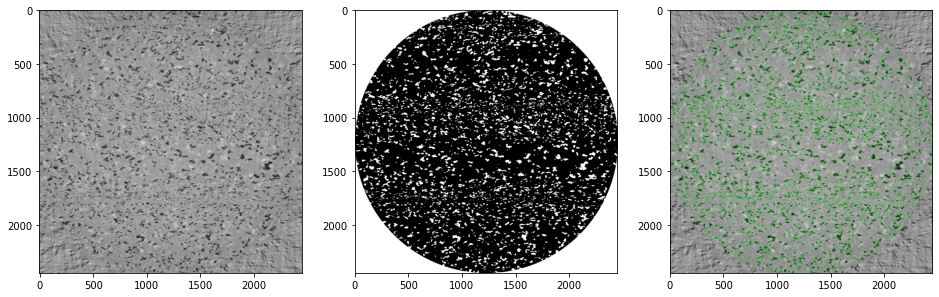

26


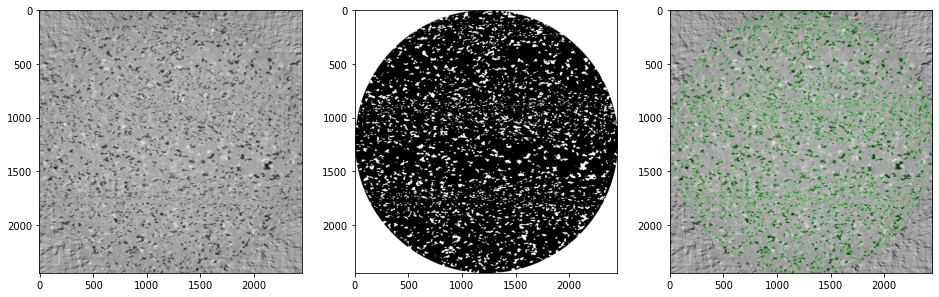

27


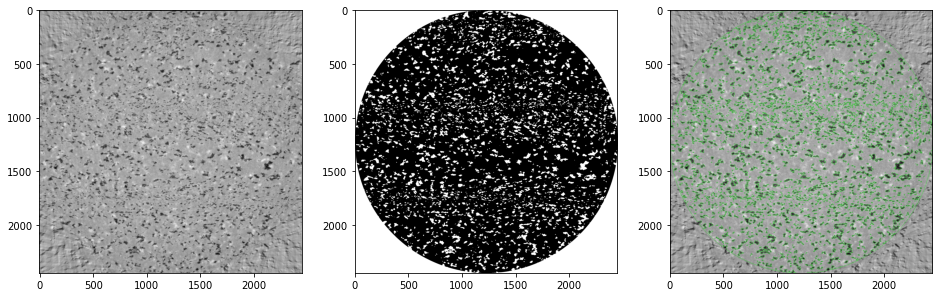

28


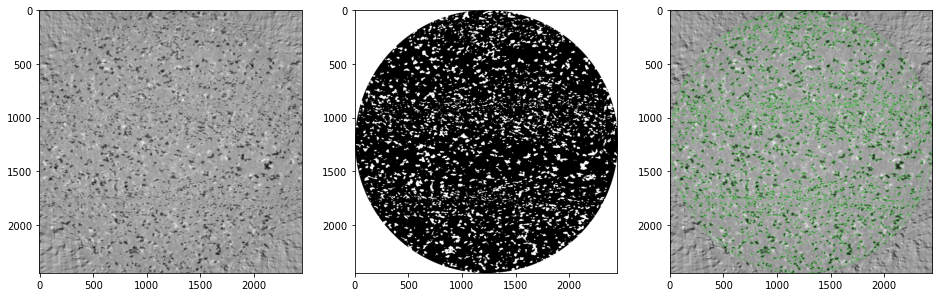

29


KeyboardInterrupt: 

In [13]:
# range_x2 = 10
# init_pos = 20
start = 0
stop = 50
for i in range(start, stop+1):
    fig, ax = plt.subplots(1,3, figsize = (16,16))
    ax[0].imshow(V_rec[i], cmap = 'gray')
    ax[1].imshow(V_seg[i], cmap = 'gray')
    viewer.edge_plot(V_rec[i],V_seg[i], ax[2])
    plt.show()
    print(i)